In [1]:
# Loading libraries
import numpy as np
import os
import scipy 
from matplotlib  import pyplot as plt
import pyntbci


##### Loading preprocessed data

In [2]:
# root directory for extracted data
root_data = r"C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_pilot_data\derivatives\pilot"

#loading: COVERT data
os.chdir(root_data)
tmp_covert = np.load("pilot_cvep_covert_mgold_61_6521_40T_ICA.npz")
X = tmp_covert["X"]
y = tmp_covert["y"]
V = tmp_covert["V"].T
fs = tmp_covert["fs"]
fr = 60

# For our experiment, we used only two classes. Hence, the flashing sequence matrix is limited to the first two codes in V.
V_needed = V[0:2,:]
V = V_needed

print("X", X.shape, "(trials x channels x samples)")  # EEG
print("y", y.shape, "(trials)")  # labels
print("V", V.shape, "(classes, samples)")  # codes
print("fs", fs, "Hz")  # sampling frequency
print("fr", fr, "Hz")  # presentation rate

# Extract data dimensions
n_trials, n_channels, n_samples = X.shape
n_classes = V.shape[0]

# Read cap file
path = r"C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyntbci\capfiles" 
capfile = os.path.join(path, "biosemi32.loc")
with open(capfile, "r") as fid:
    channels = []
    for line in fid.readlines():
        channels.append(line.split("\t")[-1].strip())
print("Channels:", ", ".join(channels))

X (40, 32, 2520) (trials x channels x samples)
y (40,) (trials)
V (2, 504) (classes, samples)
fs 240 Hz
fr 60 Hz
Channels: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, O1, Oz, O2, PO4, P4, P8, CP6, CP2, C4, T8, FC6, FC2, F4, F8, AF4, Fp2, Fz, Cz


##### Splitting data into two classes

In [3]:
# Data and codes for 'N'key/class appearing on the right
ind_0 = (y==0)
X_0 = X[ind_0,:,:] 
V_0 = V[0,:].reshape(1,504)

# # Data and codes for 'Y' key/class appearing on the left
ind_1 = (y==1)
X_1 = X[ind_1,:,:] 
V_1 = V[1,:].reshape(1,504)

# labels
'Note: In case you are computing spatial weights for just one class i.e. ONE code, make sure that y is a vector of zeros!' 
'(Why?: y is used to access M indices like M[y,...], so if M is 1 x 504 vector, only M[0,..] is an accessible dimension. For this case, if y happens to be 1 then M[1,...] will give out an index error)' 
'For more details, check line ~= 780 in classifiers.py'

y_ind=np.zeros((20,1))
print("Shape of data after separation",X_0.shape,"(trials x channels x samples)")  

Shape of data after separation (20, 32, 2520) (trials x channels x samples)


##### Combined decoder and learning curves (both classes)


Accuracy: avg=0.62 with std=0.13
ITR: avg=3.4 with std=13.05


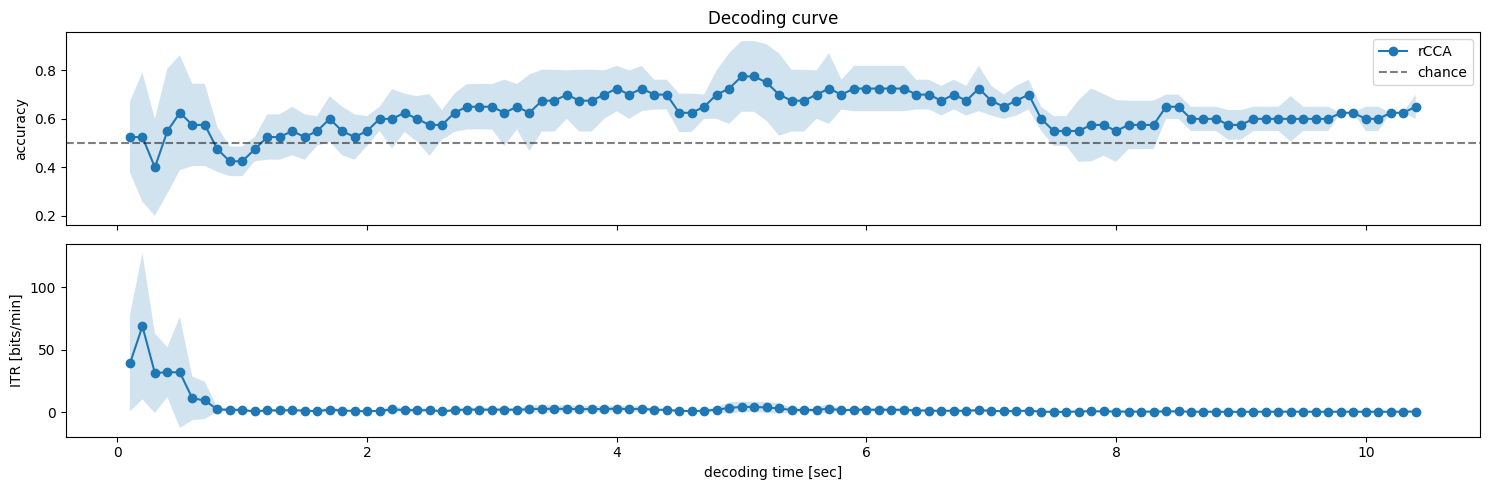

In [4]:
## Combined Decoder
trialtime = 10.5  # limit trials to a certain duration in seconds
intertrialtime = 0  # ITI in seconds for computing ITR
n_samples = int(trialtime * fs)

n_folds = 5
folds = np.repeat(np.arange(n_folds), int(X.shape[0] / n_folds))

# Set decoding curve axis
segmenttime = 0.1  # step size of the decoding curve in seconds
segments = np.arange(segmenttime, trialtime, segmenttime)
n_segments = segments.size

# Loop folds
accuracy = np.zeros((n_folds, n_segments))
for i_fold in range(n_folds):

    # Split data to train and test set
    X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

    # Setup classifier
    rcca = pyntbci.classifiers.rCCA(codes=V_needed, fs=fs, event="duration", transient_size=0.5, onset_event=True)

    # Train classifier
    rcca.fit(X_trn, y_trn)

    # Loop segments
    for i_segment in range(n_segments):

        # Apply classifier
        yh_tst = rcca.predict(X_tst[:, :, :int(fs * segments[i_segment])])

        # Compute accuracy
        accuracy[i_fold, i_segment] = np.mean(yh_tst == y_tst)

# Compute ITR
time = np.tile(segments[np.newaxis, :], (n_folds, 1))
itr = pyntbci.utilities.itr(n_classes, accuracy, time + intertrialtime)

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
avg = accuracy.mean(axis=0)
std = accuracy.std(axis=0)
ax[0].plot(segments, avg, linestyle='-', marker='o', label="rCCA")
ax[0].fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rCCA")
ax[0].axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
avg = itr.mean(axis=0)
std = itr.std(axis=0)
ax[1].plot(segments, avg, linestyle='-', marker='o', label="rCCA")
ax[1].fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rCCA")
ax[1].set_xlabel("decoding time [sec]")
ax[0].set_ylabel("accuracy")
ax[1].set_ylabel("ITR [bits/min]")
ax[0].legend()
ax[0].set_title("Decoding curve")
fig.tight_layout()

# Print accuracy (average and standard deviation over folds)
print(f"Accuracy: avg={accuracy.mean():.2f} with std={accuracy.std():.2f}")
print(f"ITR: avg={itr.mean():.1f} with std={itr.std():.2f}")

##### Running decoders for each class - get response function outputs instead of accuracy

C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chang

Accuracy: avg=0.59 with std=0.25
ITR: avg=5.4 with std=10.89


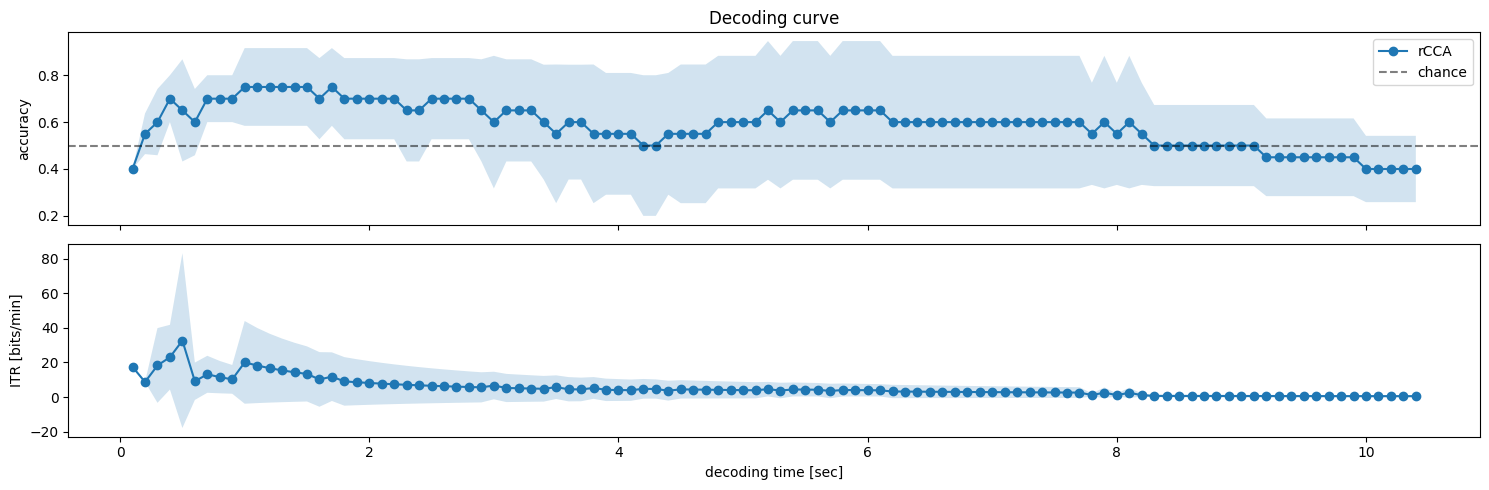

In [6]:
def class_decision(X, label,y, codes, transient_size, plot,n_folds=4):
    """Returns the output of the decision function (scores) across all folds using the rcca module

    Args:
        X (array): 
            EEG Data (trials x channels x samples)
        label (str): 
            String used for identifying the right codes to use ('0' or '1')     
        y (array): 
            Class labels for each trial
        codes (array): 
            Flashing codes used during the experiment (n_classes x samples)
        transient_size (float): 
            Duration of the neural impulse responses        
        n_folds (int, optional): 
            Number of folds used in cross validation. Defaults to 4.

    Returns:
        accuracy: 
            The percentage of accurately assigned class labels when compared to the ground truth
            
    """      
    
    trialtime = 10.5  # limit trials to a certain duration in seconds
    intertrialtime = 0  # ITI in seconds for computing ITR
    n_samples = int(trialtime * fs)

    
    segmenttime = 0.1  # step size of the decoding curve in seconds
    segments = np.arange(segmenttime, trialtime, segmenttime)
    n_segments = segments.size
    
    folds = np.repeat(np.arange(n_folds), int(X.shape[0] / n_folds))

    accuracy = np.zeros((n_folds, n_segments))
    scores_all =[]
     # Loop folds
        
    for i_fold in range(n_folds):

        # Split data to train and test set
        X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]; 
        
        # if class is 1, then for checking if np.argmax gives the right result (which is 1) we need the ground truth to be also 1. 
        # It is left as 0 otherwise (ground truth and correct argmax answer are both 0)
        if label == '0':
            y_acc_test = y_tst
        else:
            y_acc_test = np.ones_like(y_tst)
        
        # print("ytest_unch",y_tst.shape)
        # print("y_acc_test",y_acc_test.shape)
        
        
        # Setup classifier
        rcca_right = pyntbci.classifiers.rCCA(codes= codes[0,:].reshape(1,len(codes[0,:])), fs=fs, event="duration", transient_size= transient_size, onset_event= True)
        rcca_left = pyntbci.classifiers.rCCA(codes= codes[1,:].reshape(1,len(codes[1,:])), fs=fs, event= "duration", transient_size= transient_size, onset_event= True)
        

        # Train classifiers from both rccas
        rcca_right.fit(X_trn, y_trn)
        rcca_left.fit(X_trn, y_trn) # y_trn is left as 0 in both cases because there is only one class present, see line 780 in classifiers.py for more info 

        # Loop segments
        for i_segment in range(n_segments):

            # # Apply classifier
            rho_right = rcca_right.decision_function(X_tst[:, :, :int(fs * segments[i_segment])])   
            rho_left =  rcca_left.decision_function(X_tst[:, :, :int(fs * segments[i_segment])])        
            
            corr_segment = np.squeeze(np.array([rho_right, rho_left]).T) # concatenating the correlation scores made with spatio-temporal filters from both classes
            scores= np.argmax(corr_segment,axis=1) # this is where the score that is higher is chosen, it is either the first (boolean 0) or the second value (boolean 1)
            scores_all.append(scores)
            
            accuracy[i_fold,i_segment] = np.mean(scores == y_acc_test) # % of accuracy in this fold and segment
            
    if plot == True:
                
        # Compute ITR
        time = np.tile(segments[np.newaxis, :], (n_folds, 1))
        itr = pyntbci.utilities.itr(n_classes, accuracy, time + intertrialtime)

        # Plot results
        fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
        avg = accuracy.mean(axis=0)
        std = accuracy.std(axis=0)
        ax[0].plot(segments, avg, linestyle='-', marker='o', label="rCCA")
        ax[0].fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rCCA")
        ax[0].axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
        avg = itr.mean(axis=0)
        std = itr.std(axis=0)
        ax[1].plot(segments, avg, linestyle='-', marker='o', label="rCCA")
        ax[1].fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rCCA")
        ax[1].set_xlabel("decoding time [sec]")
        ax[0].set_ylabel("accuracy")
        ax[1].set_ylabel("ITR [bits/min]")
        ax[0].legend()
        ax[0].set_title("Decoding curve")
        fig.tight_layout()

        # Print accuracy (average and standard deviation over folds)
        print(f"Accuracy: avg={accuracy.mean():.2f} with std={accuracy.std():.2f}")
        print(f"ITR: avg={itr.mean():.1f} with std={itr.std():.2f}")
    
    return scores_all

scores = np.array(class_decision(X_0,'0',y = y_ind, codes = V_needed, transient_size = 0.5, plot = True))